In [1]:
import cv2 as cv
import cv2
import numpy as np
import seaborn as sns
from glob import glob


def display(title, img):
    cv.imshow(title, img)
    cv.waitKey(0)
    cv.destroyAllWindows()


### Assignment 1 Make a filterbank of DoG filters in 2 scales and 6 orientations (so 12 filters in total). Visualize the filters as in Figure 2.

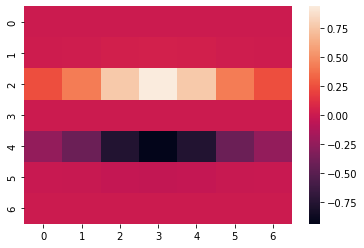

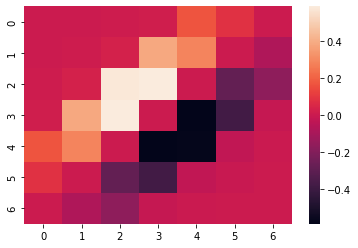

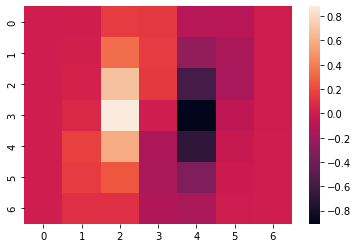

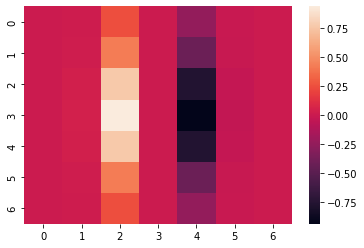

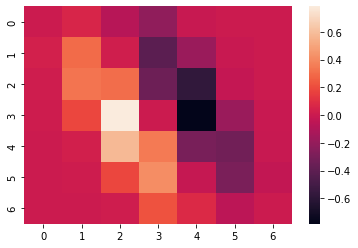

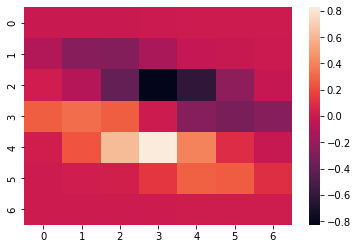

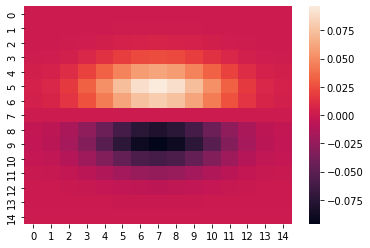

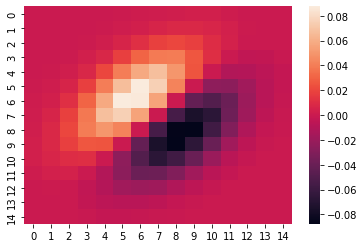

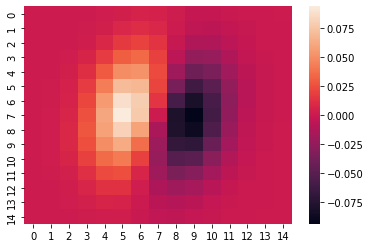

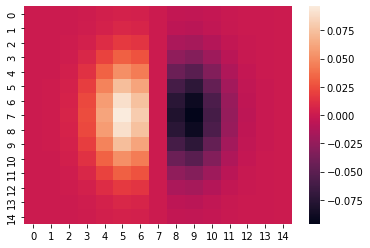

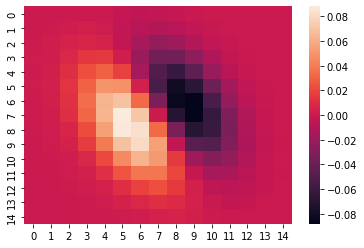

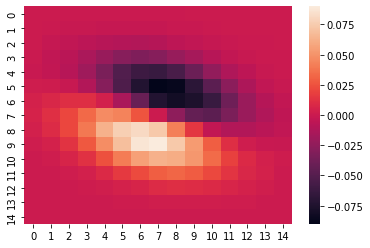

In [2]:
import matplotlib.pyplot as plt

scales = [7, 15]
rotations = [0, 45, 80, 90, 115, 160]
dogs = []

for scale in scales:
    for rotation in rotations:
        half_scale = scale//2
        dog = np.zeros((scale, scale), np.float32)
        ksize = scale
        sigma = 0.3*((ksize-1)*0.5 - 1) + 0.8 # ~2.67, this formula is from the documentation
        kernel = cv.getGaussianKernel(ksize, sigma)
        kernel = kernel.reshape((scale,)) # making it vertical
        dog[half_scale] = kernel
        kernel2 = cv.getGaussianKernel(ksize, sigma-1)
        dog = cv.filter2D(dog, -1, kernel2)
        dog = cv.Sobel(dog, -1, 0, 1, ksize=3, borderType=cv.BORDER_DEFAULT)

        rotation = cv.getRotationMatrix2D((half_scale, half_scale), rotation, 1)
        dog = cv.warpAffine(dog, rotation, (scale, scale))
        plt.figure()
        graph = sns.heatmap(dog)
        dogs.append(dog)


Assignment 2
 Filter road*.png with each of the lters. This gives you 12 lter response images. Make sure they are

oating point and contain negative values!
 Append the 12 lter response images to the blue, green and red channels to make a 15-channel image,
from which you can extract a 15-dimensional feature vector for each pixel.
 Train and test a new QDA classier on the 15-dimensional feature vectors of all pixesl of all four
images.

In [3]:
import copy

sources = sorted(glob("Images/road?.png"))
labels = sorted(glob("Images/road?_skymask.png"))

features = np.array([])
values = np.array([])


for source, label in zip(sources, labels):
    im = cv2.imread(source, 1)
    lab = cv2.imread(label, 0)
    gray = cv.cvtColor(im, cv.COLOR_BGR2GRAY)
    new_img = copy.deepcopy(im)

    for dog in dogs:
        res = cv.filter2D(gray.astype(np.float32), -1, dog, borderType=cv.BORDER_DEFAULT)
        new_img = np.append(new_img, np.reshape(res, (res.shape[0], res.shape[1], 1)), axis=2)
    
    values = np.append(values, lab)
    features = np.append(features, new_img)

features = np.reshape(features, (values.shape[0], -1))
print(features.shape)
print(values.shape)

(450560, 15)
(450560,)


In [4]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

# this discards any pixel with value not 0 or 255 from the arrays for training

which = np.union1d(np.where(values == 255), np.where(values == 0))
features = features[which, :]
values = values[which]
# initialize and train a QDA classifier
qda = QuadraticDiscriminantAnalysis()
qda.fit(features, values)
print(f'Mean training accuracy: {qda.score(features, values)}')

Mean training accuracy: 0.99045405204481


In [5]:
for source in sources:
    im = cv2.imread(source, 1)
    
    new_img = copy.deepcopy(im)
    gray = cv.cvtColor(im, cv.COLOR_BGR2GRAY)
    for dog in dogs:
        res = cv.filter2D(gray.astype(np.float32), -1, dog, borderType=cv.BORDER_DEFAULT)
        new_img = np.append(new_img, np.reshape(res, (res.shape[0], res.shape[1], 1)), axis=2)
    
    # convert to a Kx3 array that has all the pixels as rows
    im_2d = np.reshape(new_img, (new_img.shape[0] * new_img.shape[1], -1))

    plab = qda.predict(im_2d)
    # return to original image dimensions for visualization
    plab = np.reshape(plab, (new_img.shape[0], new_img.shape[1]))
    plab_color = cv2.merge((np.zeros(plab.shape, float), (plab == 255).astype(float), (plab == 0).astype(float)))

    cv2.namedWindow("predicted data")
    cv2.imshow("predicted data", 0.7 * im / 255 + 0.3 * plab_color)
    cv2.waitKey()
    cv2.destroyWindow("predicted data")

Assignment 3 Replace the QDA classier you trained in Exercise 14 with a random forest classier. Pay
attention to the main parameters:

*  the number of decision trees, controlling the overall complexity of the classier (related to the com-
plexity of the data)

* the minimum leaf size, which controls how many samples must be grouped together as a minimum at
the end of each decision tree (usually specied as a fraction of the total data).

In [9]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=25, min_samples_leaf=0.2)
rfc.fit(features, values)
print(f'Mean training accuracy: {rfc.score(features, values)}')

Mean training accuracy: 0.9290383750340061


In [7]:
for source in sources:
    im = cv2.imread(source, 1)
    
    new_img = copy.deepcopy(im)
    gray = cv.cvtColor(im, cv.COLOR_BGR2GRAY)
    for dog in dogs:
        res = cv.filter2D(gray.astype(np.float32), -1, dog, borderType=cv.BORDER_DEFAULT)
        new_img = np.append(new_img, np.reshape(res, (res.shape[0], res.shape[1], 1)), axis=2)
    
    # convert to a Kx3 array that has all the pixels as rows
    im_2d = np.reshape(new_img, (new_img.shape[0] * new_img.shape[1], -1))

    plab = rfc.predict(im_2d)
    # return to original image dimensions for visualization
    plab = np.reshape(plab, (new_img.shape[0], new_img.shape[1]))
    plab_color = cv2.merge((np.zeros(plab.shape, float), (plab == 255).astype(float), (plab == 0).astype(float)))

    cv2.namedWindow("predicted data")
    cv2.imshow("predicted data", 0.7 * im / 255 + 0.3 * plab_color)
    cv2.waitKey()
    cv2.destroyWindow("predicted data")

In [8]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier()
mlp.fit(features, values)

MLPClassifier()

In [10]:
print(f'Mean training accuracy: {mlp.score(features, values)}')

Mean training accuracy: 0.9998464675413528


In [13]:
for source, label in zip(sources, labels):
    im = cv2.imread(source, 1)
    
    new_img = copy.deepcopy(im)
    gray = cv.cvtColor(im, cv.COLOR_BGR2GRAY)
    for dog in dogs:
        res = cv.filter2D(gray.astype(np.float32), -1, dog, borderType=cv.BORDER_DEFAULT)
        new_img = np.append(new_img, np.reshape(res, (res.shape[0], res.shape[1], 1)), axis=2)
    
    # convert to a Kx3 array that has all the pixels as rows
    im_2d = np.reshape(new_img, (new_img.shape[0] * new_img.shape[1], -1))

    plab = mlp.predict(im_2d)
    # return to original image dimensions for visualization
    plab = np.reshape(plab, (new_img.shape[0], new_img.shape[1]))
    plab_color = cv2.merge((np.zeros(plab.shape, float), (plab == 255).astype(float), (plab == 0).astype(float)))

    cv2.namedWindow("predicted data")
    cv2.imshow("predicted data", 0.7 * im / 255 + 0.3 * plab_color)
    cv2.waitKey()
    cv2.destroyWindow("predicted data")

In [14]:
for source in sources:
    im = cv2.imread(source, 1)
    
    new_img = copy.deepcopy(im)
    gray = cv.cvtColor(im, cv.COLOR_BGR2GRAY)
    for dog in dogs:
        res = cv.filter2D(gray.astype(np.float32), -1, dog, borderType=cv.BORDER_DEFAULT)
        new_img = np.append(new_img, np.reshape(res, (res.shape[0], res.shape[1], 1)), axis=2)
    
    # convert to a Kx3 array that has all the pixels as rows
    im_2d = np.reshape(new_img, (new_img.shape[0] * new_img.shape[1], -1))

    plab = mlp.predict(im_2d)
    # return to original image dimensions for visualization
    plab = np.reshape(plab, (new_img.shape[0], new_img.shape[1]))
    plab_color = cv2.merge((np.zeros(plab.shape, float), (plab == 255).astype(float), (plab == 0).astype(float)))

    cv2.namedWindow("predicted data")
    cv2.imshow("predicted data", 0.7 * im / 255 + 0.3 * plab_color)
    cv2.waitKey()
    cv2.destroyWindow("predicted data")